# Localizing Personal Protective Equipment Using Mask R-CNN

### Authors-

* Siddharth Mathur - siddharth.mathur@colorado.edu
* Abhijay Tyagi - abhijay.tyagi@colorado.edu
* Arihant Sikarwar - arihant.sikarwar@colorado.edu
* Lohith Ramesh - lohith.ramesh@colorado.edu


### Introduction-

One of the fundamental principles of any establishment is a devotion to safety. "Safety First" cannot be just lip service from higher management; it should be enacted, establishing a powerful security culture within the organisation. Worksite safety should take precedence over all other considerations, including expenses, efficiency, and timelines. Employees are an organization's most valuable asset; demonstrating to them that their safety is a top priority upon each venture inculcates confidence and establishes trust. Prioritizing safety can help save money and increase productivity on the job. Mishaps cause budget overruns and production delays. As safety improves, fewer days are lost due to accidents and injuries. A good safety record can also help save money on insurance.

Even after rigorous vulnerability assessments and adopting adequate protective measures, workers might still be subject to health and safety hazards. These hazards could range from a slick floor to falling debris. As a first line of defence, companies need to ensure that all employees are wearing proper fitted Personal Protective Equipment (PPE). PPE includes protective items like hardhats, high-visibility jackets, safety footwear, and eye protection.

Personal protective equipment is any wearable item that a worker may use while being on the job to avert any workplace hazards. This can range from a full-body suit for a firefighter to gloves and an apron for a cook. Depending on the requirements of the job, PPE may include helmets, goggles, body armour, foot and hand protection, and any other tools that achieve the same objective. Employers are also responsible for ensuring that workers follow instructions on how to use the proper personal protective equipment.

Specific types of protective equipment are appropriate for particular types of work because personal protective equipment varies by industry. For instance, it is mandatory for construction workers to wear steel-toed boots and helmets to protect their feet and heads, respectively. While in a biochemical lab, 'moonsuits' are required. The frequency of certain types of workplace accidents has a big impact on this.

The existing measure entails time-consuming manual checks to ensure all employees are wearing proper PPEs, but this research introduces a new system that uses computer vision and deep learning to segment, localise and detect people and PPEs. The model uses Mask R-CNN on a self-annotated dataset corresponding to 3 classes, namely, Person, Helmet (Hard hats) and Jackets. These classes are added on to the Microsoft Common Objects in Context (MS COCO) dataset that has annotated images corresponding to 80 classes with a total of 330k+ images.

Feature extraction, training and testing are the three major phases of this system. The system utilizes deep learning technology to train itself with various images of hard hats, people, and jackets.


### Goal of the Project-
The project aims at employing deep learning and computer vision to localize Personal Protective Equipments from images to help organizations improve employee safety.


Since we have a huge daatset that was collected by scraping the internet, we had to store it on google drive. To access it, we first mount our drive onto our colab notebook. *(Kindly mail siddharthmathur20@gmail.com to access the dataset)*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing some of the required dependencies. *(Make sure the library version is similar to ones mentioned because Mask-RCNN works on these versions)*

In [ ]:
!pip install tensorflow==1.14
!pip install keras==2.2.5
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 51 kB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
     |████████████████████████████████| 3.1 MB 49.4 MB/s 
     |████████████████████████████████| 488 kB 69.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
    Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
ERROR: pip's dependency resolver does not currently ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 336 kB 5.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Let's start by importing some of the required libraries for our analysis. Other than tensorflow and keras, we need to import Mask-RCNN to access our model and weights.

In [ ]:
import os
#import keras
#import tensorflow.python.keras.engine
#from keras.layers import Layer
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import imgaug
# import skimage.draw
from matplotlib import pyplot as plt
# Root directory of the project
ROOT_DIR = ('/content/drive/My Drive/GarudaUAV/Mask_RCNN')

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
# from mrcnn import model as modellib, utils
from mrcnn import visualize
# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

We first configure our Mask-RCNN model based on several hyperparameters. Better results can be achieved by finetuning our model architecture. Mask-RCNN can work on a 'ResNet-50' or a 'ResNet-101' backbone architecture. For our analysis we have used the 'ResNet-50' model. You can also initialize the loss weights, a short description of each loss weight is added as a comment.

The final model architecture is shown as the output of the below cell.

In [ ]:
############################################################
#  Configurations
############################################################
class GarudaConfig(Config):
    """Configuration for training on the toy dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "garuda"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + objects

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    BACKBONE = 'resnet50'
    # Skip detections with < 90% confidence
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)
    # TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50
    # POST_NMS_ROIS_INFERENCE = 500
    # POST_NMS_ROIS_TRAINING = 1000
    LOSS_WEIGHTS = {
          "rpn_class_loss": 1.0, # How well the Region Proposal Network separates background with objetcs
          "rpn_bbox_loss": 0.7, # How well the RPN localize objects
          "mrcnn_class_loss": 1.0, # How well the Mask RCNN localize objects
          "mrcnn_bbox_loss": 1.0, # How well the Mask RCNN recognize each class of object
          "mrcnn_mask_loss": 1.0 # How well the Mask RCNN segment objects
    }


config = GarudaConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 0.7, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        # Add the class names using the base method from utils.Dataset
        source_name = "garuda"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                try:
                  image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                  image_annotations = annotations[image_id]

                  # Add the image using the base method from utils.Dataset
                  self.add_image(
                      source=source_name,
                      image_id=image_id,
                      path=image_path,
                      width=image_width,
                      height=image_height,
                      annotations=image_annotations
                  )
                except KeyError as key1:
                  print('Id not found. Skipping')
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids





### About Data

Dataset Used

Images are the type of data used in this project. The dataset was collated from various web sources and have publicly available images of people, hardhats, and jackets. A sample of the images used for our analysis are added below.

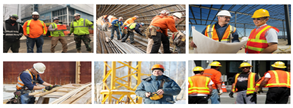






The **training** dataset contains **955** images, while the **testing** dataset contains **183** images. The class distribution in the training and testing dataset are as shown in Table 1 and Table 2 respectively.

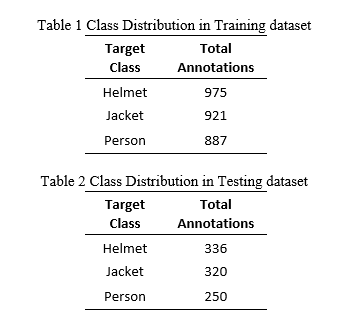

*From the table above it is easy to realise that our dataset is a bit imbalanced. This imbalanced dataset, multiple hyperparameters, backbone architecture are some variables that would lead to accuracy loss and model bias.*

### Annotating Dataset-
To make our dataset usable for the Mask R-CNN model, every image needs to be meticulously annotated for our objects of interest to achieve the highest level of accuracy.

**Labelme** is being used to annotate the data. Labelme is a Python-based graphic annotation tool with a Qt-based graphical user interface. It can be used for both image and video annotations and has annotations for polygon, circle, line, rectangle, and point.

The MS COCO dataset is organised into five main sections: info, licence, images, categories, and annotations. It is formatted in JSON. It has 2 types of annotations, bounding box and polygon mask. Since our system implements Instance Segmentation, each class in an image has its respective polygon annotation. The annotation section contains a list of every single object annotation from each image in the dataset. There will be 90 helmet annotations, for instance, if there are 90 helmets distributed among 120 images (along with a tonne of annotations for other object categories). In an image, an object will frequently appear in more than one place.

Since our dataset is annotated using Labelme, we need to format it according to COCO format. To do this, we use labelme2coco. Labelme2coco is a lightweight python package that converts labelme annotations into COCO object detection format. Sample annoted image from dataset is shown below

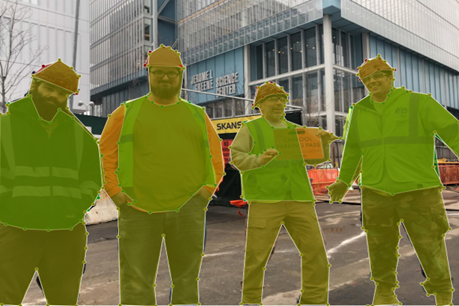

The training and testing dataset is then loaded from Google Drive to our Colab notebook. (The path displayed is the relative path to our image dataset)

In [ ]:
dataset_train = CocoLikeDataset()
# dataset_train.load_data('/content/drive/My Drive/GarudaUAV/Garuda/Train_Images/traincoco.json', '/content/drive/My Drive/GarudaUAV/Garuda/Train_Images')
dataset_train.load_data('/content/drive/My Drive/GarudaUAV/Garuda/fromlabelme/t1/trainval.json', '/content/drive/My Drive/GarudaUAV/Garuda/fromlabelme/t1')
dataset_train.prepare()


In [ ]:
dataset_val = CocoLikeDataset()
# dataset_val.load_data('/content/drive/My Drive/GarudaUAV/Garuda/Val_Images/valcoco.json', '/content/drive/My Drive/GarudaUAV/Garuda/Val_Images/')
dataset_val.load_data('/content/drive/My Drive/GarudaUAV/Garuda/fromlabelme/v1/trainval.json', '/content/drive/My Drive/GarudaUAV/Garuda/fromlabelme/v1')
dataset_val.prepare()

# ***Modelling - Mask R-CNN***
Mask R-CNN is a variant of Faster R-CNN. Mask R-CNN includes an additional branch for predicting segmentation masks on each Region of Interest (ROI) pixel-by-pixel, whereas Faster R-CNN does not.
For each object of interest in an image, faster R-CNN produces two outputs: a class label and a bounding box enclosing the object. Mask R-CNN, however, generates three outputs: an object mask covering the object(s) of interest in an image, a class label, and a bounding box.
* Faster R-CNN and Mask R-CNN function similarly. In Mask R-CNN, there are two main phases:

*	Like Faster R-CNN, the Region Proposal Network (RPN) suggests potential object bounding boxes in the first phase.

*	In the second phase, a binary mask for each Region of Interest (ROI) is predicted in addition to the class label and bounding box.

## Mask R-CNN pipeline:

*	ResNet 101 is used to extract features from an image.

*	The Region Proposal Network (RPN) is used to process the feature maps that were extracted in the previous step. We only get feature maps that the model predicts will contain an object.

*	All the regions are shaped uniformly by applying a pooling layer (RoI Align) to the feature maps.

*	The class label and bounding box are then predicted by a fully connected layer using these regions.

*	To speed up computation, we only compute the Intersection of Union (IoU) for each predicted region with the ground truth boxes.


                            IoU = Area of Intersection / Area of Union

*	The Region of Interest (RoI) is taken into consideration if the IoU is greater than or equal to 0.5. If not, the RoI is neglected. All regions go through this process, and only those that satisfy the IoU requirements are selected.
*	These features are then fed into the Mask Classification model, which is composed of two CNN architectures and produces a binary mask for each ROI. Mask R-CNN model architecture is shown below


We create a Mask-RCNN training object and set up our class names.

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


class_names = ['BG', 'helmet', 'jacket', 'Person']







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

We then start training our model. For our analysis we run 10 epochs with data augmentation to generalize our model weights. Our learning rate is similar to what was defined during model architecture above. (It took us 11 hours to train our model for 10 epochs!!!!!!!!!!!!!)

In [ ]:
augmentation = imgaug.augmenters.Fliplr(0.5)
start_train = time.time()
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads',
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


We plot our Mask-RCNN training and validation losses using tensorflow's tensorboard connectivity. TensorBoard is a great tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

Our models loss graphs are shown below.
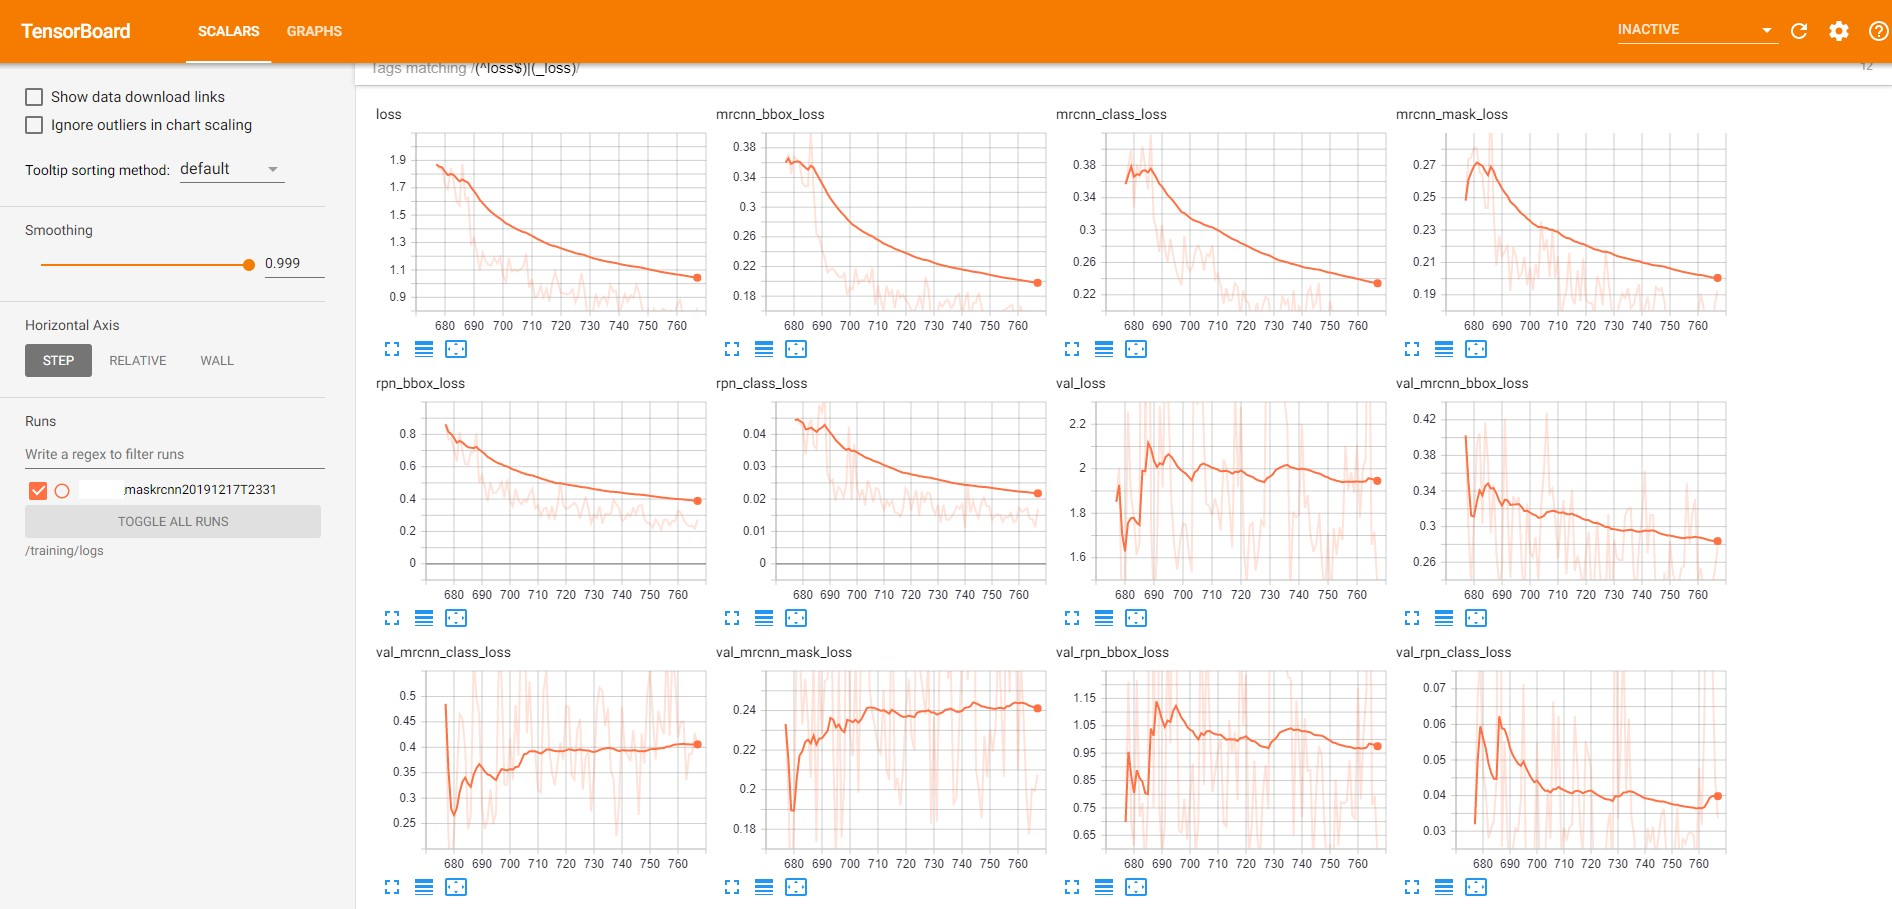

Finally, after training, we choose the model with the best weights and run our model on the test set. We only localize objects that are detected with atleast 80% confidence. A bouding box with an accuracy label is added to our test images.

In [ ]:
class InferenceConfig(GarudaConfig):
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8


inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
# assert model_path != "", "Provide path to trained weights"
# print("Loading weights from ", model_path)
model_path = '/content/drive/My Drive/GarudaUAV/Mask_RCNN/logs/garuda20200310T1957/mask_rcnn_garuda_0006.h5'
model.load_weights(model_path, by_name=True)

import skimage
real_test_dir = '/content/drive/My Drive/GarudaUAV/Garuda/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                dataset_val.class_names, r['scores'], figsize=(15,15))

````
Loading weights from  /content/drive/My Drive/GarudaUAV/Mask_RCNN/logs/garuda20211220T1336/mask_rcnn_garuda_0001.h5
Re-starting from epoch 4
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32
````

![image](https://user-images.githubusercontent.com/32820754/165591084-201d313b-7ac3-4dc0-9181-34a26b98c151.png)

````
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32
````
![image](https://user-images.githubusercontent.com/32820754/165591184-590ee040-82ff-423f-b66b-cf448fa21b28.png)

````
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    0.99885  float32
````
![image](https://user-images.githubusercontent.com/32820754/165591275-fddffa22-e8c4-48c5-963e-19ec8734ac77.png)


# ***RESULTS AND DISCUSSION***
As you might notice from the output, not all the objects in some images were detected by the model. Also, there were no objects detected at all in some of the test images. This speaks towards the accuracy and efficiency of our model.

*We use the Intersection-Over-Union (IoU), also known as the Jaccard Index, and mean Average Precision to evaluate the performance of our model.*

1. **Intersection-Over-Union** (IoU):
IoU is calculated as the ratio of the area of overlap between the predicted segmentation and the ground truth to the area of union between the two.

Mathematically,

image.png

The JAC (Jaccard Index) value ranges from 0 to 1. (0-100 percent). Here 0 signifies no overlap and 1 signifies complete overlap segmentation.
IoU is calculated for each class in multi-class segmentation and averaged. So, for our system, we calculated the Jaccard Indices for helmet, jacket, person, and the background and averaged them to get a matrix of size (4 x 1).

2.	**Mean Average Precision (mAP)**
mAP calculates the average accuracy of predicted object locations across all object predictions, compared to ground truth object predictions, and assigns equal importance to each object. mAP is based on the IoU, Precision, Recall, and Confusion Matrix.
Precision is the proportion of correct positive predictions to all positive predictions.
Recall is the proportion of correct positive predictions to total observations in the actual class.
The weighted average of precisions at each threshold is used to calculate Average Precision (AP). The recall improvement over the previous threshold determines the weight. mAP can be computed by obtaining the Average Precision (AP) for every class and then averaging it over several classes.

Mathematically,

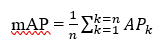


Here, AP_k = the AP of class k, and n = number of classes
For our model, to compute Average Precision, we have used an IoU threshold of 0.5. We calculated the mAP for each class for all our test images and then computed their average. Results for the ResNet-50 models are compared in the table below

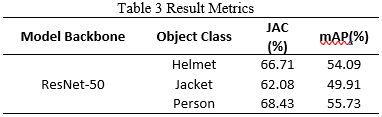


# ***CONCLUSION***
Assuring employee safety is critical for an organization's efficiency. PPEs serve as a preliminary dense wall, protecting employees and securing the workplace. Since manually checking to see if each employee is wearing proper PPEs can be time-consuming, a system that detects, classifies, localises, and segments these PPEs can be useful.
The results of the proposed system show that Mask R-CNN is very efficient in localising and segmenting PPEs when done with the ResNet-50 model. By using a more advanced dataset with higher-quality images and adding more classes, a more robust system can be built. Further advancements in hardware and software technologies can also improve output accuracy significantly.